# Exam project in Scientific Computing With Python A.Y. 2023/2024

Course number: INQ2100742

Professor: Alberto Zucchetta

Assistant: Dr. Rocco Ardino

Group members:

    - Andrea Sandbu Numme (student ID: 2099720)
    - Anna Matzen (student ID: 2099629)
    - Antonin Zeman (student ID: 2100168)
    - Fattokh Bakhtiyor Ugli Sadriddinov (student ID: 2085453)


The following text is part of the given project description:

## Analysis of Vodafone users' fluxes

The study of the flux of people inside urban areas is of paramount importance to achieve an optimal understanding of emerging critical issues in the local mobility, and to explore areas of potential improvements in the infrastructures and local transports.

The mobility of users within and toward Padova has been monitored using the data provided by the Vodafone mobile carrier, which provides the information based on the users' connections to the network cells.
The data provided by the carrier encompasses the monitoring of the users connected to the Vodafone network in Padova in a four-month period from February to May of 2018.

To provide statistical insights on the number and the flow of users, the data is aggregated based on the origin and movements of the users by averaging the number of connections during the time of the monitoring.

To further avoid privacy violation issues, all observations with less than 30 units (e.g. day-areas for which $<$30 users have contributed) have been discarded and/or merged into dedicated categories (indicated with "altro", or "other").


## Datasets 

The data is provided in `.csv` files.

* __day_od.csv__: table of the origins and destinations of the users averaged by the day of the week. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).
* __distinct_users_day.csv__: table of the number of distinct users by origin. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).

The information is stored in the fields according to the following scheme: 

- __MONTH__: month analyzed
- __DOW__: day analyzed
- __ORIGIN__: users' origin area (do not consider this field)
- __DESTINATION__: users' destination area (do not consider this field)
- __CUST_CLASS__: user type (resident / Italian visitor / foreigner visitor)
- __COD_COUNTRY__: users' country code (e.g. 222=Italy)
- __COD_PRO__: users' province code (e.g. 12=Varese) 
- __PRO_COM__: users' comune code (e.g. 12026=Busto Arsizio)
- __FLOW__: number of movements for given date-time (with a minimum of 30 users)
- __VISITORS__: overall number of users 

Together with the data files, three lookup-tables are provided to allow matching the Italian institute of STATistics (ISTAT) country, province and comune codes to the actual names.

* __codici_istat_comune.csv__: lookup file containing the mapping between _comune_ ISTAT code-names
* __codici_istat_provincia.csv__: lookup file containing the mapping between _province_ ISTAT code-names
* __codici_nazioni.csv__: lookup file containing mapping the _country_ code to its name

# Assignment 1: Data preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns
from scipy import stats
import warnings

The five files for exercise 1 are loaded. As the files comes form different sources, their encodings are not the same and they require different parameters to load the files. For `pd.read_csv()` the default encoding is `'utf-8'`, but for files 1, 2 and 5, the encoding is `'latin1'` and for file 3 and 4 it is `'utf-16'`. 

In [3]:
file1 = "./Exercise_files/codici_istat_comune.csv"
file2 = "./Exercise_files/codici_istat_provincia.csv"
file3 = "./Exercise_files/codici_nazioni.csv"
file4 = "./Exercise_files/day_od.csv"
file5 = "./Exercise_files/distinct_users_day.csv"

df_comune = pd.read_csv(file1, encoding='latin1',header=0)
df_provincia = pd.read_csv(file2, encoding='latin1',header=0)
df_nazioni = pd.read_csv(file3, encoding='utf-16',header=0)
df_day_od = pd.read_csv(file4, encoding='utf-16', header=0)
df_distinct = pd.read_csv(file5, encoding='latin1', header=0)

## 1.1 Ranking of visitors from foreign countries

In the dataset `'day_od.csv'` people's origin is classified into 4 classes under `CUST_CLASS`: 

    - 'visitor'
    - 'resident'
    - 'foreigner'
    - 'altro'
    
For this exercise, only the class `'foreigner'` will be analyzed. The class `'altro'` does not have any country-code connected, as they are a collection of people from areas where <30 has been registered. Out of the original dataset of 1.741.509 lines, the category `'altro'`makes up 7.537 of them and the category `'foreigner'` makes up 11.190. 

In [4]:
#Extract all rows that contains 'altro'  
altro_df = df_day_od[df_day_od['CUST_CLASS'].str.contains('altro', case=False)] 
print('Number of lines with altro:', altro_df.shape[0])

Number of lines with altro: 7537


In [5]:
#Extract all rows that contains foreigners  
foreigner_df = df_day_od[df_day_od['CUST_CLASS'].str.contains('foreigner', case=False)] 
print('Number of lines with foreigner:', foreigner_df.shape[0])

Number of lines with foreigner: 11190


Now we want to analyze which countries are most represented in the `'foreigner'`category. This is done by counting the appearance of each country code in the column `'COD_COUNTRY'` in the DataFrame containing the foreigners. 

In [6]:
#Count number of times each country code is represented 
foreigner_counts = foreigner_df['COD_COUNTRY'].value_counts().reset_index() 

#Name the columns
foreigner_counts.columns = ['COD_COUNTRY', 'Foreigner_Count']  

#Look up the name corresponding to the countrycode
result_df = pd.merge(foreigner_counts, df_nazioni, on='COD_COUNTRY', how='left') 

#'-999' represents unknows origin. Also, to handle the NaN, we replace it with 'Unknown origin'
result_df['COUNTRY_NAME_IT'].fillna('Unknown origin', inplace=True) 

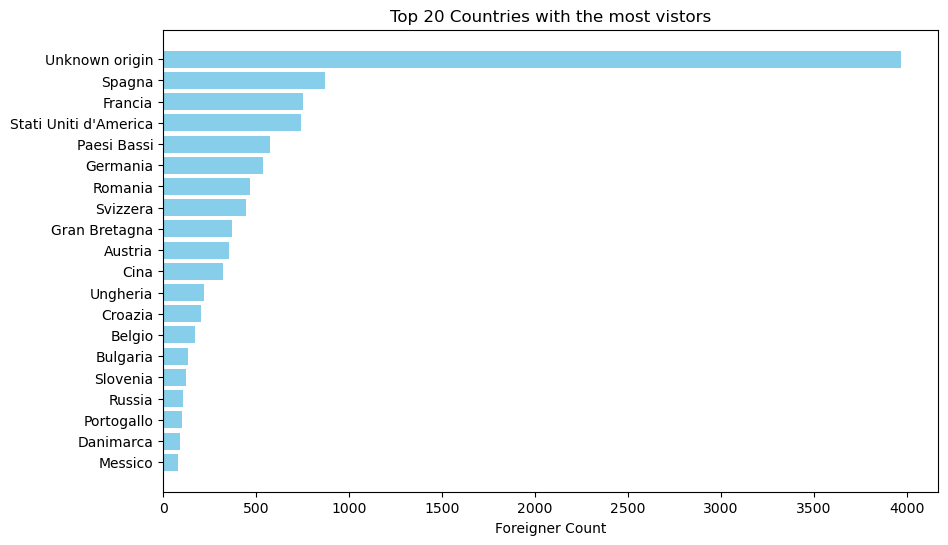

'unknown origin' appears: 3969 times


In [7]:
#Choose the 20 top represented countries and plot them in a histogram 
top_20_countries = result_df.nlargest(20, 'Foreigner_Count') #Only use the top 20 

#Create a ranked plot
plt.figure(figsize=(10, 6))
plt.barh(top_20_countries['COUNTRY_NAME_IT'], top_20_countries['Foreigner_Count'], color='skyblue')
plt.xlabel('Foreigner Count')
plt.title('Top 20 Countries with the most vistors')
plt.gca().invert_yaxis()  
plt.show()

unknown_origin_count = result_df[result_df['COUNTRY_NAME_IT'] == 'Unknown origin']['Foreigner_Count'].sum()
print("'unknown origin' appears:", unknown_origin_count, "times")

As the country most represented is of unknown origin, which are countries that in the data set does not have a known country code, an alternative to the plot above is shown below. In this alternative, we remove the category `'Unknown origin'` and simply show the most represented foreigner from known countries.

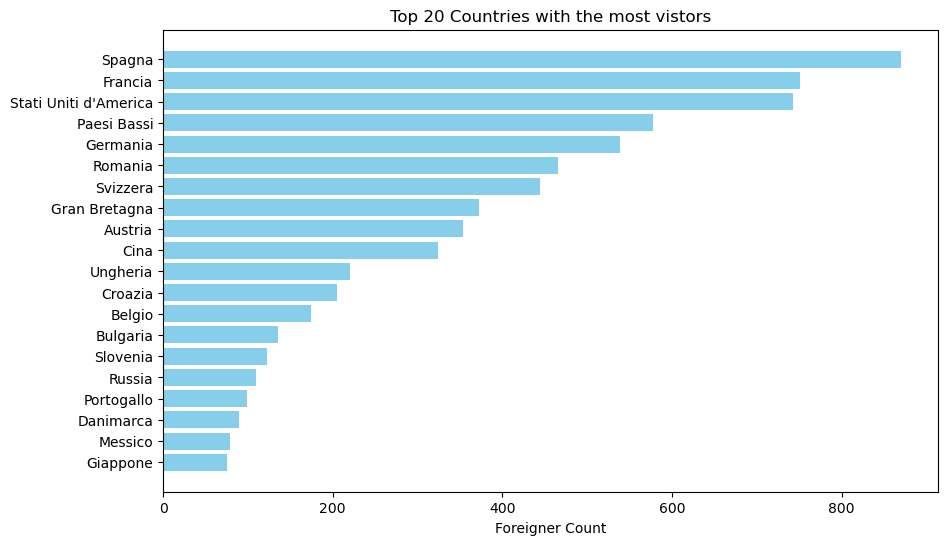

In [8]:
#Filter out 'Unknown origin'
result_df_filtered = result_df[result_df['COUNTRY_NAME_IT'] != 'Unknown origin'] 

#Choose top 20 countries
top_20_countries = result_df_filtered.nlargest(20, 'Foreigner_Count') #Only use the top 20 

#Create a ranked plot
plt.figure(figsize=(10, 6))
plt.barh(top_20_countries['COUNTRY_NAME_IT'], top_20_countries['Foreigner_Count'], color='skyblue')
plt.xlabel('Foreigner Count')
plt.title('Top 20 Countries with the most vistors')
plt.gca().invert_yaxis()  
plt.show()

From the plots above, we can see that the foreigners are mostly with unknown origin, followed by Spain, France and the US. This indicates that there are many foreign visitors from distant countries, not only European foreigners come visit, which is a good sign for the turism. 

People in the category `'altro'` makes up 7.537 and people with unknown origin counts for 3.969 out of the 11.190 in the category `'foreigners'`. 

## 1.2 Ranking Italian visitors by province

Now we look at the Italian visitors coming from other provinces of the country. Since the provinces in Italy range widely in the number of inhabitants, it is valid to see how many visitors are going in and out of Padova, weighted by the number of inhabitants in their home province. 

First we clean the data set in order to remove any NaNs. This is done now, since the category `'foreigners'` used in the previous part contained many NaNs but were still valid to include in the analysis of most visitors from other countries. 

In [9]:
#Filter all rows where there are Nan's 
df_day_od_cleaned = df_day_od.dropna() #remove NaN's
Removed = df_day_od.shape[0]-df_day_od_cleaned.shape[0] #calculate the number removed 
print('Before cleaning:', df_day_od.shape, 'and after cleaning', df_day_od_cleaned.shape, '. Removed', Removed, 'rows')

Before cleaning: (193501, 9) and after cleaning (186280, 9) . Removed 7221 rows


Now we isolate all the Italian visitors from the cleaned data set. 

In [10]:
#Extract all the visitors 
visitor_df = df_day_od_cleaned[df_day_od_cleaned['CUST_CLASS'].str.contains('visitor', case=False)]
print('Number of cells with visitors:', visitor_df.shape[0])

Number of cells with visitors: 145480


Now we count the appearances of each province code in the DataFrame containing the visitors. The counts of visitors from each province code is then computed into a new column in the DataFrame called `'Visitor_Count'`. Afterwards, we look up which province each provice code corresponds to. This is done using the data set `'df_provincia'` provided in the project as well. By merging the two data sets on the column `'COD_PRO'` we connect each province code with the name of the province. 

In [11]:
#Count number of times each province code is represented 
visitors_counts = visitor_df['COD_PRO'].value_counts().reset_index() 

#Name the columns
visitors_counts.columns = ['COD_PRO', 'Visitor_Count']  

#To look up the name corresponding to the countrycode
result_province_df = pd.merge(visitors_counts, df_provincia, on='COD_PRO', how='left') 
print(result_province_df)

    COD_PRO  Visitor_Count  COD_REG             PROVINCIA PROV_SIGLA
0      28.0          82276      5.0                Padova         PD
1    -999.0          21600   -999.0                 Altro         ND
2      27.0          13054      5.0               Venezia         VE
3      24.0           5255      5.0               Vicenza         VI
4      26.0           4465      5.0               Treviso         TV
..      ...            ...      ...                   ...        ...
89     81.0              2     19.0               Trapani         TP
90    103.0              2      1.0  Verbano-Cusio-Ossola         VB
91     55.0              2     10.0                 Terni         TR
92     11.0              1      7.0             La Spezia         SP
93     56.0              1     12.0               Viterbo         VT

[94 rows x 5 columns]


Now the information about the inhabitants in all the provinces of Italy is downloaded from the following website: 
http://dati.istat.it/viewhtml.aspx?il=blank&vh=0000&vf=0&vcq=1100&graph=0&view-metadata=1&lang=en&QueryId=18460&metadata=DCIS_POPRES1

Here, only the provinces present in the DataFrame are chosen to be part of the imported data set, as it can be constructed dynamically. When the data is read, the irrelevant columns from the dataset are dropped and the name of the column `'Territory'` is changed to `'PROVINCIA'` in order to match with the corresponding column from the DataFrame `'result_province_df'` showed above.

In [13]:
# Reading the data containing population numbers for provinces in Italy:
file6 = "./Exercise_files/data/population_provinces.csv"
population_provinces = pd.read_csv(file6, header=0)

# Dropping irrelevant columns from dataframe, only keeping the population number for each province
column_to_drop = ['ITTER107','TIPO_DATO15','Demographic data type','SEXISTAT1','Gender','ETA1','Age',
                  'STATCIV2','Marital status','Select time','TIME','Flag Codes','Flags']
population_provinces_cut = population_provinces.drop(column_to_drop, axis=1)

# Renaming the column "Territory" to match the dataframe "result_province_df" for merge
popu_prov = population_provinces_cut.rename(columns={'Territory': 'PROVINCIA'})

popu_prov

,PROVINCIA,Value
0,Torino,2204632
1,Vercelli,165892
2,Biella,169106
3,Verbano-Cusio-Ossola,154038
4,Novara,362502
...,...,...
102,Agrigento,413177
103,Siracusa,384866
104,Oristano,150325
105,Monza e della Brianza,873606


Now the DataFrame showed above is ready to be merged with the DataFrame `'result_province_df'`. It is then possible to see which provinces have the most visitors.

In [14]:
# Merging the two dataframes on the column "PROVINCIA"
all_info_provinces = pd.merge(result_province_df, popu_prov, on='PROVINCIA', how='left')
all_info_provinces

,COD_PRO,Visitor_Count,COD_REG,PROVINCIA,PROV_SIGLA,Value
0,28.0,82276,5.0,Padova,PD,930349.0
1,-999.0,21600,-999.0,Altro,ND,NaN
2,27.0,13054,5.0,Venezia,VE,835895.0
3,24.0,5255,5.0,Vicenza,VI,852779.0
4,26.0,4465,5.0,Treviso,TV,878828.0
...,...,...,...,...,...,...
89,81.0,2,19.0,Trapani,TP,415006.0
90,103.0,2,1.0,Verbano-Cusio-Ossola,VB,154038.0
91,55.0,2,10.0,Terni,TR,217183.0
92,11.0,1,7.0,La Spezia,SP,214872.0


In order to get the weighted number of visitors by the number of inhbitants in their home province, a new column is constructed, where the number of visitors from each province is divided by the number of inhabitants from that province. This will yield a weighted ordering of the number of visitors.

In [15]:
# Creating a new column to the datafile containing the number of visitors divided by the number of inhabitants
all_info_provinces['visitors / inhabitants'] = all_info_provinces['Visitor_Count'] / all_info_provinces['Value']
all_info_provinces

,COD_PRO,Visitor_Count,COD_REG,PROVINCIA,PROV_SIGLA,Value,visitors / inhabitants
0,28.0,82276,5.0,Padova,PD,930349.0,0.088436
1,-999.0,21600,-999.0,Altro,ND,NaN,NaN
2,27.0,13054,5.0,Venezia,VE,835895.0,0.015617
3,24.0,5255,5.0,Vicenza,VI,852779.0,0.006162
4,26.0,4465,5.0,Treviso,TV,878828.0,0.005081
...,...,...,...,...,...,...,...
89,81.0,2,19.0,Trapani,TP,415006.0,0.000005
90,103.0,2,1.0,Verbano-Cusio-Ossola,VB,154038.0,0.000013
91,55.0,2,10.0,Terni,TR,217183.0,0.000009
92,11.0,1,7.0,La Spezia,SP,214872.0,0.000005


Now a plot can be constructed showing the top 20 provinces with the most visitors. This is done using the new column `'visitors / inhabitants'` created above and the column `'PROVINCIA'` containing the names of the provinces. The first 20 provinces with the most visitors taking into account the number of inhabitants are found by selecting the 20 largest values from the column `'visitors / inhabitants'`. 

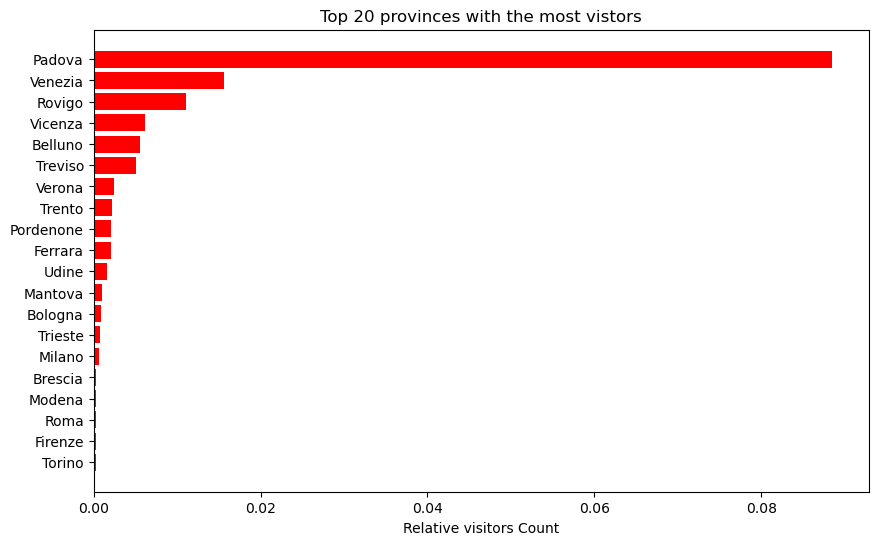

In [16]:
#Only use the top 20 
top_20_provinces = all_info_provinces.nlargest(20, 'visitors / inhabitants') 

#Create a ranked plot
plt.figure(figsize=(10, 6))
plt.barh(top_20_provinces['PROVINCIA'], top_20_provinces['visitors / inhabitants'], color='red')
plt.xlabel('Relative visitors count')
plt.title('Top 20 provinces with the most vistors')
plt.gca().invert_yaxis()  
plt.show()

As can be seen from the plot above, the number of visitors per province is relative to the number of inhabitants and therefore more a measure to be compaired against eachother than a value to be interpreted on its own. 

From the plot above it is clear that the province "Padova" is the provice with the most visitors, taking into account the number of inhabitants. This is though a little misleading, since even though these are marked as `'visitors'`their province of origin is Padova, indicating that they could also be residents, given that the data set contains information about movements in and out of Padova. In order to make up for this confusion, a second plot is provided below, showing the 20 top visiting provinces without Padova included. 

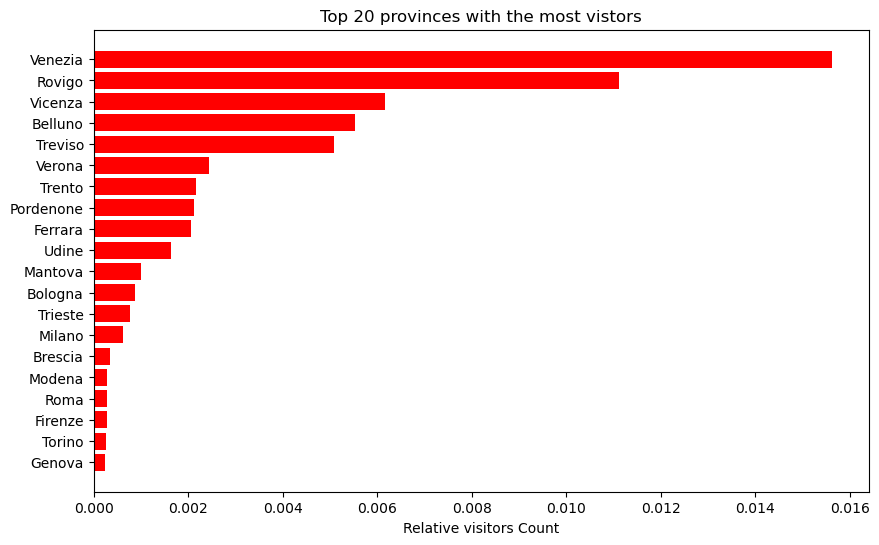

In [17]:
#Filter out 'Padova'
provinces_u_padova = all_info_provinces[all_info_provinces['PROVINCIA'] != 'Padova']

#Use the top 20 provinces
top_20_provinces_new = provinces_u_padova.nlargest(20, 'visitors / inhabitants') 

#Create a ranked plot
plt.figure(figsize=(10, 6))
plt.barh(top_20_provinces_new['PROVINCIA'], top_20_provinces_new['visitors / inhabitants'], color='red')
plt.xlabel('Relative visitors count')
plt.title('Top 20 provinces with the most vistors')
plt.gca().invert_yaxis()  
plt.show()

In the plot above we see that most of the visitors coming to Padova from other provinces are from the close by provinces located in Veneto, with Venezia being the most visiting province. 

It has now been analyzed which provinces visit Padova the most, taking into account the number of inhabitants in the province of origin. The results from the analysis showed that Padova ranked highest on the visitors, but to avoid confusion a second analysis was performed, excluding the province of Padova, in which we saw that the province of Venezia ranked the highest, weighted by the number of inhabitants.

# __Assignment 2: Study of the visitors' fluxes__

## Preliminary info

We are asked to consider the three main routes from Padova (listed below). This can be done on a large scale - with provinces located on the routes through Italy, on a medium scale - provinces located on the routes in the Veneto region only, and on a small scale - communes located on the routes in the Padova province only. 

- __Route one__ - Milano/Torino <-> Padova (A4)

- __Route two__ - Roma <-> Padova (A13)

- __Route three__ - Venice/Trieste <-> Padova (A4)

-----------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------
    

### Following is the pre-processing of data for both exercise 2.1 and 2.2

In [24]:
#Read the files and convert to dataframes 
file7 = "./Exercise_files/data/Communes.csv"
file8 = "./Exercise_files/data/Population_Italy_2019.csv"
fileRovigo = "./R05_RO.csv"
fileVicenza = "./R05_VI.csv"
fileVerona = "./R05_VR.csv"
fileVenezia = "./R05_VE.csv"

df_population_comunnes = pd.read_csv(file7)
df_population_province = pd.read_csv(file8)
df_Venezia = pd.read_csv(fileVenezia,sep=";")
df_Rovigo = pd.read_csv(fileRovigo,sep=";")
df_Vicenza = pd.read_csv(fileVicenza,sep=";")
df_Verona = pd.read_csv(fileVerona,sep=";")

In [25]:
# Defining the routes:
Route_one_small = ["Vescovana", "Boara Pisani", "Stanghella", "Solesino", "Monselice", "Pernumia", "Due Carrare", "Maserà di Padova", "Albignasego"]
Route_two_small = ["Mestrino", "Villafranca Padovana", "Rubano"]
Route_three_small = ["Vigonza", "Noventa Padovana", "Cadoneghe"]
Route_one = ["Vicenza","Verona","Brescia","Bergamo","Monza e della Brianza","Milano","Novara","Vercelli","Torino"]
Route_two = ["Rovigo","Ferrara","Bologna","Firenze","Arezzo","Siena","Perugia","Terni","Rieti", "Viterbo", "Roma"]
Route_three = ["Venezia","Treviso","Udine","Gorizia","Trieste"]

The first step requires a treatment (preparation) of the files. Every file we use in this exercise includes additional information that we don't need. So in this step, we filter out additional data. The file: "data/Population_Italy_2019.csv" for example includes statistics for both males and females, directional files on the other hand include specific communes of origin and different unnecessary codes. So we drop the unnecessary columns, filter out Nans, and apply masks vanishing the rows we don't need (males and females). 

The second step is to extract the information we need. This is again done by masks. Masks were created in previous steps and include the main communes or provinces depending on the type of analysis. Another mask at first maybe not obvious is the commune code of Padova (28060), this one is used for extracting only the people that are going to Padova commune (case 3). Creating the final masks for provinces and communes is done by comparing the names of the communes and provinces to the look-up files extracting the corresponding codes of the provinces (communes) which are then made into a list and applied as a mask. The last mask introduced is for days of the week (used for case 4). 

After this step, we have prepared data frames that contain only the information we are interested in. In cases 1 and 2. We have data frames containing provinces and communes we are interested in with the number of visitors for each of them. We then merge this data frame with the number of inhabitants per commune (province) and weigh it by it. 

In case 3 we have a data frame that contains all the communes from a specific province whose destination was Padova and their time spent on the road. There is no need to merge here. We only sum all the contributions and divide the sum of all the kilometers by the sum of the time. 

In case 4 the procedure is really similar to cases 1 and 2 but here divided our search into weekend visitors and weekdays visitors. 

In [26]:
# Mask to get total number (population is split into male and female)
mask_males_and_females = (df_population_comunnes['Gender'] == 'Males') | (df_population_comunnes['Gender'] == 'Females')

# clean files from unnecessary columns and apply mask
drop_columns = ["REF_AREA", "FREQ", "Frequency", "DATA_TYPE", "Indicator", "SEX", "Gender", 
                   "AGE", "Age (DESC)", "MARITAL_STATUS", "Marital status", "Time (TIME_PERIOD)", 
                   "OBS_STATUS", "Observation status"]
df_population_comunnes_filtered = df_population_comunnes[~mask_males_and_females].drop(drop_columns,axis=1)
df_population_province_filtered = df_population_province[~mask_males_and_females].drop(drop_columns,axis=1)

##################################################

#Case 1

# Mask: containing communes we are interested in
mask_com = Route_one_small + Route_two_small + Route_three_small
communes_final = df_population_comunnes_filtered[df_population_comunnes_filtered["Territory"].isin(mask_com)].rename(columns={"Observation" : "Population","Territory" : "COMUNE"})
df_distint_cleaned = df_distinct.dropna() #remove NaN's
Removed = df_distinct.shape[0]-df_distint_cleaned.shape[0] #calculate the number removed
visitors_dis = df_distint_cleaned[df_distint_cleaned['CUST_CLASS'].str.contains('visitor', case=False)] 

##################################################

# Case 2 
# Mask: containing provinces we are interested in
mask_province = ["Verona", "Vicenza", "Rovigo","Venezia"]
province_final = df_population_province_filtered[df_population_province_filtered["Territory"].isin(
    mask_province)].rename(columns={"Observation" : "Population","Territory" : "PROVINCIA"})

##################################################

# Case 4 
# Mask: containing provinces we are interested in
mask_province_3 = Route_one + Route_two + Route_three
temp_province_3 = df_provincia[df_provincia["PROVINCIA"].isin(mask_province_3)].drop(columns=["PROV_SIGLA","COD_REG"])
province_final_2 = df_population_province_filtered[df_population_province_filtered["Territory"].isin(
                                mask_province_3)].rename(columns={"Observation" : "Population","Territory" : "PROVINCIA"})

##################################################

# Apply the correct mask and drop unnecessary columns
temp_com = df_comune[df_comune["COMUNE"].isin(mask_com)].drop(columns=["COMUNE_CAPOLUOGO","COD_PRO"]) 
temp_province = df_provincia[df_provincia["PROVINCIA"].isin(mask_province)].drop(columns=["PROV_SIGLA","COD_REG"])

# Make a list of codes of interest
mask_com_2 = temp_com["PRO_COM"].tolist()
mask_province_2 = temp_province["COD_PRO"].tolist()
mask_province_4 = temp_province_3["COD_PRO"].tolist()

# Finally, apply the mask to the visitor's file, drop unnecessary columns, and sum the number of visitors.  
visitors_dis_com = visitors_dis[visitors_dis["PRO_COM"].isin(mask_com_2)].drop(
    columns=['DOW',"CUST_CLASS",'COD_PRO','COD_COUNTRY']).groupby(["PRO_COM"]).sum()
visitors_dis_province = visitors_dis[visitors_dis["COD_PRO"].isin(mask_province_2)].drop(columns=['DOW',"CUST_CLASS",'PRO_COM','COD_COUNTRY']).groupby(["COD_PRO"]).sum()
visitors_dis_province_2 = visitors_dis[visitors_dis["COD_PRO"].isin(mask_province_4)].drop(columns=["CUST_CLASS",'PRO_COM','COD_COUNTRY'])

##################################################

# Case 4 - apply mask for workers and weekend and remove unnecessary columns and sum
mask_weekend = ["Domenica","Sabato"]
mask_workers = ["Lunedì","Martedì","Mercoledì","Giovedì","Venerdì"]
vstrs_ds_pr2 = visitors_dis_province_2
dis_pr_weekend = vstrs_ds_pr2[vstrs_ds_pr2["DOW"].isin(mask_weekend)].drop(columns=["DOW"]).groupby(["COD_PRO"]).sum()
dis_pr_workers = vstrs_ds_pr2[vstrs_ds_pr2["DOW"].isin(mask_workers)].drop(columns=["DOW"]).groupby(["COD_PRO"]).sum()

##################################################

# Merging, weighing by population and sorting
#case 1
temp_visitors = pd.merge(visitors_dis_com, temp_com, on='PRO_COM', how='left') # First merge to connect visitors with communes names
visitors_dis_com_final = pd.merge(temp_visitors, communes_final, on='COMUNE', how='left') # Second merge to connect visitors with populations
visitors_dis_com_final['visitors / inhabitants'] = visitors_dis_com_final['VISITORS'] / visitors_dis_com_final['Population'] # Weigh by population
visitors_dis_com_final_sorted = visitors_dis_com_final.sort_values(by=['visitors / inhabitants']) # Sort

#case 2
temp_visitors_2 = pd.merge(visitors_dis_province, temp_province, on='COD_PRO', how='left') 
visitors_dis_province_final_temp = pd.merge(temp_visitors_2, province_final, on='PROVINCIA', how='left') 
sum_temp = visitors_dis_province_final_temp.iloc[:2].sum() 
sum_df = pd.DataFrame([["-", sum_temp['VISITORS'], "Vicenza + Verona", sum_temp["Population"]]], \
                        columns=visitors_dis_province_final_temp.columns) 
visitors_dis_province_final = pd.concat([visitors_dis_province_final_temp, sum_df])
visitors_dis_province_final['visitors / inhabitants'] = visitors_dis_province_final['VISITORS'] /  \
                                     visitors_dis_province_final['Population'] # Weigh by population
visitors_dis_province_final_sorted = visitors_dis_province_final.sort_values(by=['visitors / inhabitants']) # Sort

#case 4
temp_dis_pr_weekend = pd.merge(dis_pr_weekend, temp_province_3, on='COD_PRO', how='left') 
dis_pr_weekend_final = pd.merge(temp_dis_pr_weekend, province_final_2, on='PROVINCIA', how='left') 
temp_dis_pr_workers = pd.merge(dis_pr_workers, temp_province_3, on='COD_PRO', how='left') 
dis_pr_workers_final = pd.merge(temp_dis_pr_workers, province_final_2, on='PROVINCIA', how='left') 


C:\Users\fatto\AppData\Local\Temp\ipykernel_24248\901182729.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_population_province_filtered = df_population_province[~mask_males_and_females].drop(drop_columns,axis=1)


In [51]:
#Case 3

# Drop unnecessary columns and rename remaining columns for easy understanding
df_Venezia_cleaned_temp = df_Venezia.drop(columns=['OR_DEST',"OR_REG","OR_PROCOM","DEST_REG","DEST_PROV","TEP_TOT","OR_PROV"])
df_Venezia_cleaned = df_Venezia_cleaned_temp.rename(columns={'KM_TOT': 'Kilometers','TTP_TOT ': 'Time'})
df_Venezia_cleaned['Kilometers'] = df_Venezia_cleaned['Kilometers'].str.replace(',', '.').astype(float)
df_Venezia_to_PD_Pr = df_Venezia_cleaned[df_Venezia["DEST_PROCOM"] == 28060]
df_Venezia_to_PD_Pr_sum = df_Venezia_to_PD_Pr.groupby(["DEST_PROCOM"]).sum()
df_Venezia_to_PD_Pr_sum["Time/Km"] = df_Venezia_to_PD_Pr_sum['Kilometers']/df_Venezia_to_PD_Pr_sum['Time'] 
df_Venezia_to_PD_Pr_sum['Region'] = ["Venezia"] # Name change

df_Rovigo_cleaned_temp = df_Rovigo.drop(columns=['OR_DEST',"OR_REG","OR_PROCOM","DEST_REG","DEST_PROV","TEP_TOT","OR_PROV"])
df_Rovigo_cleaned = df_Rovigo_cleaned_temp.rename(columns={'KM_TOT': 'Kilometers','TTP_TOT ': 'Time'})
df_Rovigo_cleaned['Kilometers'] = df_Rovigo_cleaned['Kilometers'].str.replace(',', '.').astype(float)
df_Rovigo_to_PD_Pr = df_Rovigo_cleaned[df_Rovigo["DEST_PROCOM"] == 28060]
df_Rovigo_to_PD_Pr_sum = df_Rovigo_to_PD_Pr.groupby(["DEST_PROCOM"]).sum()
df_Rovigo_to_PD_Pr_sum["Time/Km"] = df_Rovigo_to_PD_Pr_sum['Kilometers']/df_Rovigo_to_PD_Pr_sum['Time']
df_Rovigo_to_PD_Pr_sum['Region'] = ["Rovigo"]

df_Vicenza_cleaned_temp = df_Vicenza.drop(columns=['OR_DEST',"OR_REG","OR_PROCOM","DEST_REG","DEST_PROV","TEP_TOT","OR_PROV"])
df_Vicenza_cleaned = df_Vicenza_cleaned_temp.rename(columns={'KM_TOT': 'Kilometers','TTP_TOT ': 'Time'})
df_Vicenza_cleaned['Kilometers'] = df_Vicenza_cleaned['Kilometers'].str.replace(',', '.').astype(float)
df_Vicenza_cleaned
df_Vicenza_to_PD_Pr = df_Vicenza_cleaned[df_Vicenza_cleaned["DEST_PROCOM"] == 28060]
df_Vicenza_to_PD_Pr_sum = df_Vicenza_to_PD_Pr.groupby(["DEST_PROCOM"]).sum()
df_Vicenza_to_PD_Pr_sum["Time/Km"] = df_Vicenza_to_PD_Pr_sum['Kilometers']/df_Vicenza_to_PD_Pr_sum['Time']
df_Vicenza_to_PD_Pr_sum['Region'] = ["Vicenza"]

df_Verona_cleaned_temp = df_Verona.drop(columns=['OR_DEST',"OR_REG","OR_PROCOM","DEST_REG","DEST_PROV","TEP_TOT","OR_PROV"])
df_Verona_cleaned = df_Verona_cleaned_temp.rename(columns={'KM_TOT': 'Kilometers','TTP_TOT ': 'Time'})
df_Verona_cleaned['Kilometers'] = df_Verona_cleaned['Kilometers'].str.replace(',', '.').astype(float)
df_Verona_cleaned
df_Verona_to_PD_Pr = df_Verona_cleaned[df_Verona_cleaned["DEST_PROCOM"] == 28060]
df_Verona_to_PD_Pr_sum = df_Verona_to_PD_Pr.groupby(["DEST_PROCOM"]).sum()
df_Verona_to_PD_Pr_sum["Time/Km"] = df_Verona_to_PD_Pr_sum['Kilometers']/df_Verona_to_PD_Pr_sum['Time']
df_Verona_to_PD_Pr_sum['Region'] = ["Verona"]

df_Vi_Ve = pd.concat([df_Verona_cleaned, df_Vicenza_cleaned])
df_Vi_Ve_to_PD_Pr = df_Vi_Ve[df_Vi_Ve["DEST_PROCOM"] == 28060]
df_Vi_Ve_to_PD_Pr_sum = df_Vi_Ve_to_PD_Pr.groupby(["DEST_PROCOM"]).sum()
df_Vi_Ve_to_PD_Pr_sum["Time/Km"] = df_Vi_Ve_to_PD_Pr_sum['Kilometers']/df_Vi_Ve_to_PD_Pr_sum['Time']
df_Vi_Ve_to_PD_Pr_sum['Region'] = ["Vicenza + Verona"]

# Combining results and sorting
All = pd.concat([df_Vi_Ve_to_PD_Pr_sum,df_Rovigo_to_PD_Pr_sum,df_Venezia_to_PD_Pr_sum])
All_sorted = All.sort_values(by=['Time/Km']) # Sort

In [1]:
# print(df_Vicenza_to_PD_Pr_sum)
# print(df_Verona_to_PD_Pr_sum)
# print(All_sorted)

In [28]:
# Case 4

# Apply the mask for provinces on the first route + to dataframe
Weekend_Route_one_temp = dis_pr_weekend_final[dis_pr_weekend_final["PROVINCIA"].isin(Route_one)].sum()
Workers_Route_one_temp = dis_pr_workers_final[dis_pr_workers_final["PROVINCIA"].isin(Route_one)].sum()

# To dataframe
Weekend_Route_one = pd.DataFrame([[None, Weekend_Route_one_temp["VISITORS"], "Torino <--> Padova", Weekend_Route_one_temp["Population"]]], columns=dis_pr_weekend_final.columns)
Workers_Route_one = pd.DataFrame([[None, Workers_Route_one_temp["VISITORS"], "Torino <--> Padova", Workers_Route_one_temp["Population"]]], columns=dis_pr_workers_final.columns) 

# Apply the mask for provinces on the second route + to dataframe
Weekend_Route_two_temp = dis_pr_weekend_final[dis_pr_weekend_final["PROVINCIA"].isin(Route_two)].sum()
Weekend_Route_two = pd.DataFrame([[None, Weekend_Route_two_temp["VISITORS"], "Bologna <--> Padova", Weekend_Route_two_temp["Population"]]], columns=dis_pr_weekend_final.columns) 
Workers_Route_two_temp = dis_pr_workers_final[dis_pr_workers_final["PROVINCIA"].isin(Route_two)].sum()
Workers_Route_two = pd.DataFrame([[None, Workers_Route_two_temp["VISITORS"], "Bologna <--> Padova", Workers_Route_two_temp["Population"]]], columns=dis_pr_workers_final.columns)

# Apply the mask for provinces on the third route + to dataframe
Weekend_Route_three_temp = dis_pr_weekend_final[dis_pr_weekend_final["PROVINCIA"].isin(Route_three)].sum()
Weekend_Route_three = pd.DataFrame([[None, Weekend_Route_three_temp["VISITORS"], "Trieste <--> Padova", Weekend_Route_three_temp["Population"]]], columns=dis_pr_weekend_final.columns) 
Workers_Route_three_temp = dis_pr_workers_final[dis_pr_workers_final["PROVINCIA"].isin(Route_three)].sum()
Workers_Route_three = pd.DataFrame([[None, Workers_Route_three_temp["VISITORS"], "Trieste <--> Padova", Workers_Route_three_temp["Population"]]], columns=dis_pr_workers_final.columns)

All_weekend = pd.concat([Weekend_Route_one,Weekend_Route_two,Weekend_Route_three])
All_workers = pd.concat([Workers_Route_one,Workers_Route_two,Workers_Route_three])

# Weekend
All_weekend['visitors / inhabitants'] = All_weekend['VISITORS'] / All_weekend['Population'] # Weigh by population
All_weekend_sorted = All_weekend.sort_values(by=['visitors / inhabitants']) # Sort
dis_pr_weekend_final['visitors / inhabitants'] = dis_pr_weekend_final['VISITORS'] / dis_pr_weekend_final['Population'] # Weigh by population
dis_pr_weekend_final_sorted = dis_pr_weekend_final.sort_values(by=['visitors / inhabitants']) # Sort

# Workers
All_workers['visitors / inhabitants'] = All_workers['VISITORS'] / All_workers['Population'] # Weigh by population
All_workers_sorted = All_workers.sort_values(by=['visitors / inhabitants']) # Sort
dis_pr_workers_final['visitors / inhabitants'] = dis_pr_workers_final['VISITORS'] / dis_pr_weekend_final['Population'] # Weigh by population
dis_pr_workers_final_sorted = dis_pr_workers_final.sort_values(by=['visitors / inhabitants']) # Sort

# __2.1 Mid-range mobility__

Here we are interested in small-scale and medium-scale routes. Our analysis was done for three cases. Repository https://github.com/openpolis/geojson-italy was used to determine communes and provinces located on the routes listed below. 

- __Case 1__: Small scale - Communes in the Padova province

    - Route one: Vescovana, Boara Pisani, Stanghella, Solesino, Monselice, Pernumia, Due Carrare, Maserà di Padova, Albignasego
    - Route two: Mestrino, Villafranca Padovana, Rubano
    - Route three: Vigonza, Noventa Padovana, Cadoneghe


- __Case 2__: Medium scale - Provinces in Veneto 

    - Route one: Rovigo
    - Route two: Verona, Vicenza
    - Route three: Venezia
    

- __Case 3__: Medium scale - provinces in Veneto - cost of one kilometer

In this case, we used a different approach to answer the question of which of the three directions/routes has to be prioritized. A ".zip" package containing the distances between comuni in the Veneto region was obtained and the cost of one kilometer in time was calculated to determine whether visitors/commuters spend more time per kilometer  on any of the directions/routes.

------------------------------------------------------------------------------------------------------------------------------------------------------------

## CASE 1

In this first case we wish to investigate how many visitors are coming to Padova from the communes in the Padova province, in order to determine which of the three small-scale routes should be prioritized.

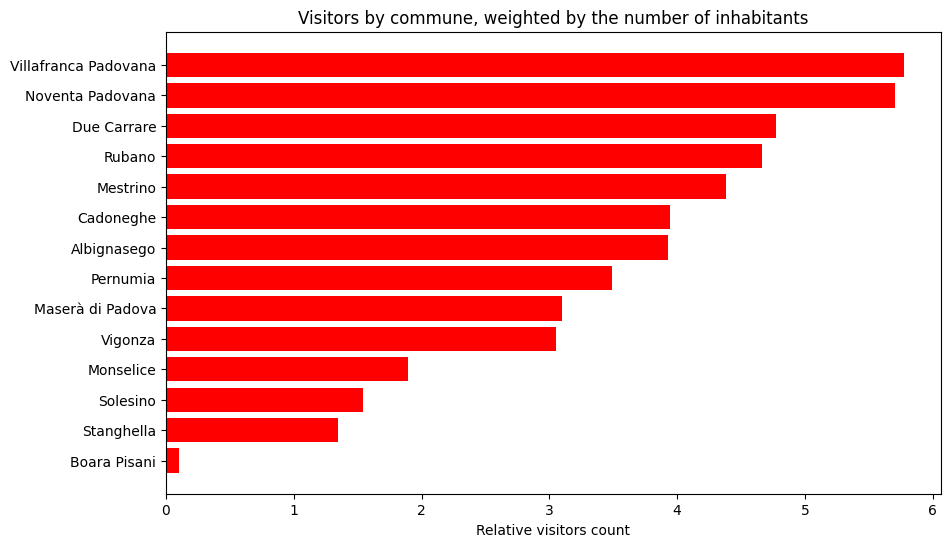

In [29]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(visitors_dis_com_final_sorted['COMUNE'], visitors_dis_com_final_sorted['visitors / inhabitants'], color='red')
plt.xlabel('Relative visitors count')
plt.title('Visitors by commune, weighted by the number of inhabitants') 
plt.show()

#### __Case 1 - conclusion__
From the plot above, we can see the sorted number of visitors by commune, weighted by the number of inhabitants. For many commuters/visitors from nearby regions, the main highways are not always the only or best choice/option, but it can be seen that, for example the commune "Due Carrare," located south of Padova, has a high number of visitors/commuters, and for this commune, the best option is highway A13, suggesting that this highway could be prioritized. 

-----------------------------------------------------------------------------------------------------------------------------------------------------------

## CASE 2

In this second case we wish to investigate how many visitors are coming to Padova from the other provinces in Veneto in order to determine which of the three medium-scale routes should be prioritized.

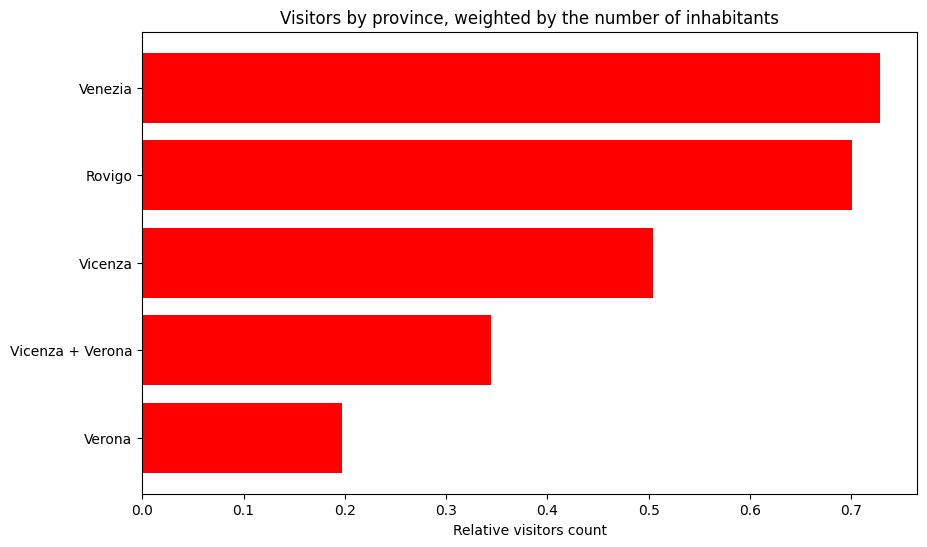

In [30]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(visitors_dis_province_final_sorted['PROVINCIA'], visitors_dis_province_final_sorted['visitors / inhabitants'], color='red')
plt.xlabel('Relative visitors count')
plt.title('Visitors by province, weighted by the number of inhabitants') 
plt.show()

#### __Case 2 - conclusion__
From the plot above, we can see the sorted number of visitors by province, weighted by the number of inhabitants. The result is similar to what we have seen in section one, but here we can make more conclusions. We can see that Venezia province has the highest number of visitors per inhabitants, suggesting that the highway A4 towards Venice-Trieste should be prioritized. Rovigo province, however, has a similar number of visitors per inhabitant, and from what was seen in the previous case, our temporary conclusion is to prioritize the A13 towards Bologna-Roma.

-----------------------------------------------------------------------------------------------------------------------------------------------------------

## CASE 3

In this third case we wish to investigate the cost of kilometers on the three medium-scale routes going to Padova from the provinces in Veneto.

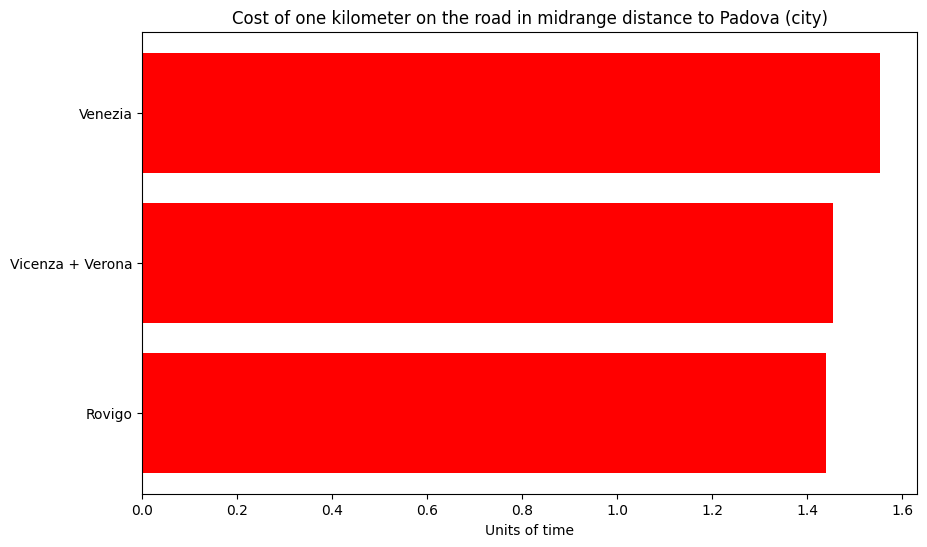

In [40]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(All_sorted['Region'], All_sorted['Time/Km'], color='red')
plt.xlabel('Time/Km')
plt.title('Cost of one kilometer on the road in midrange distance to Padova (city)')
plt.show()

#### __Case 3 - conclusion__
From the plot above, we can see the cost of one kilometer in time. The route to Venezia province costs the most. From previous cases, the decision on what route (highway) should be prioritized was between A4 towards Venice-Trieste and A13 towards Bologna-Roma. Case three however points more towards A4 towards Venice-Trieste given that the cost of one kilometer is an important metric. 

-----------------------------------------------------------------------------------------------------------------------------------------------------------

# 2.2 Large-scale mobility

Here we are interested in large-scale mobility taking into account all provinces located on the main routes. They are listed below. On top of that we are interested in different groups of visitors/commuters. Namely "working daily commuters" and "weekend visitors". This could help us decide on what direction should be prioritized. We used the same repository as in 2.1 to gather the information about the routes.

- __Case 4__: Large-scale mobility - Provinces in Italy 

    - Route one: Vicenza, Verona, Brescia, Bergamo, Monza e Brianza, Milano, Novara, Vercelli, Torino
    - Route two: Rovigo, Ferrara, Bologna, Firenze, Arezzo, Siena, Perugia, Terni, Rieti, Viterbo, Roma
    - Route three: Venezia, Treviso, Udine,   Gorizia,  Trieste
           

## CASE 4

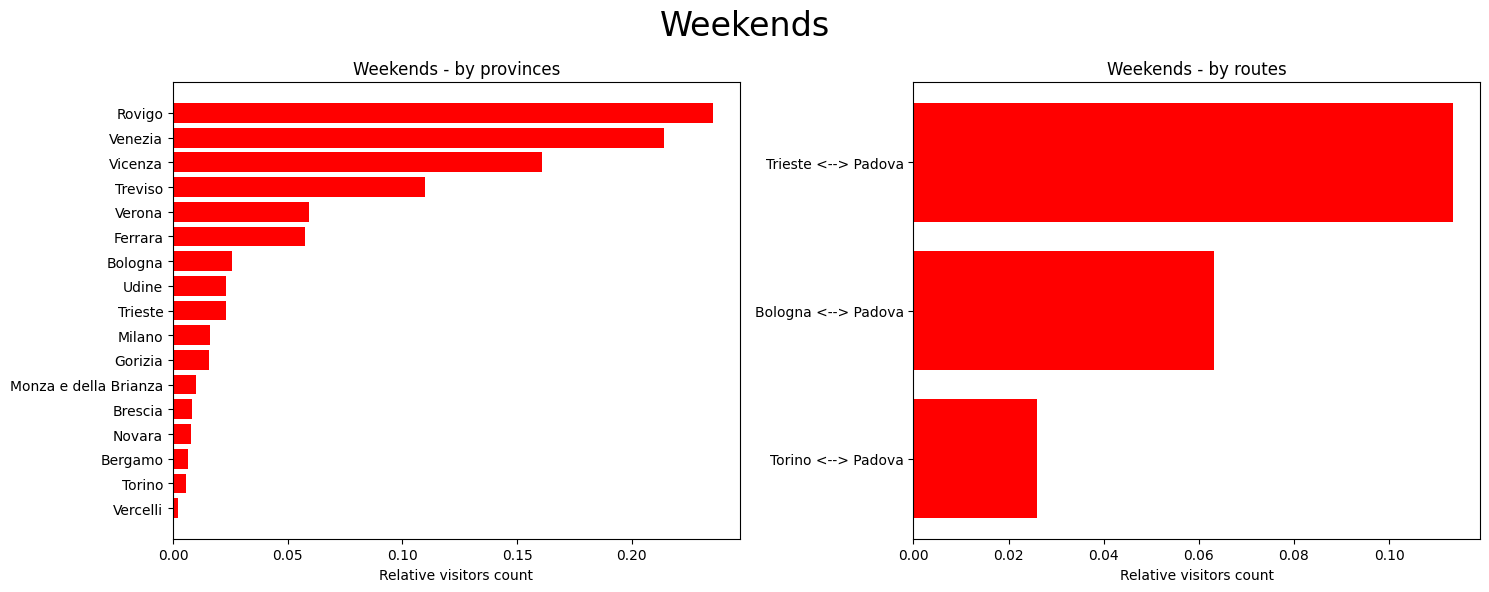

In [32]:
# Plot for weekend visitors
plt.figure(figsize=(15, 6))

# Plot for dis_pr_weekend_final_sorted
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.barh(dis_pr_weekend_final_sorted['PROVINCIA'], dis_pr_weekend_final_sorted['visitors / inhabitants'], color='red')
plt.xlabel('Relative visitors count')
plt.title('Weekend visitors - by provinces')

# Plot for All_weekend_sorted
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.barh(All_weekend_sorted['PROVINCIA'], All_weekend_sorted['visitors / inhabitants'], color='red')
plt.xlabel('Relative visitors count')
plt.title('Weekend visitors - by routes')
plt.suptitle('Weekend visitors',fontsize=24)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

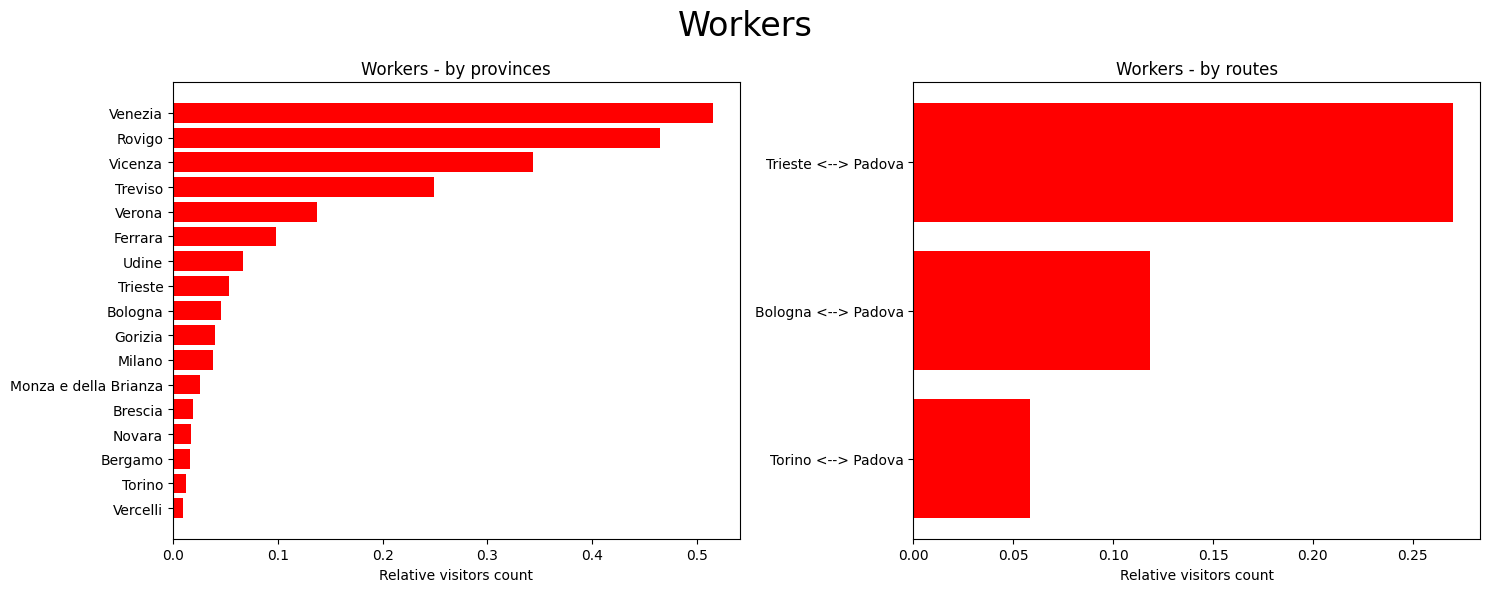

In [33]:
# Plot for working daily commuters
plt.figure(figsize=(15, 6))

# Plot for dis_pr_weekend_final_sorted
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.barh(dis_pr_workers_final_sorted['PROVINCIA'], dis_pr_workers_final_sorted['visitors / inhabitants'], color='red')
plt.xlabel('Relative visitors count')
plt.title('Working daily commuters - by provinces')

# Plot for All_weekend_sorted
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.barh(All_workers_sorted['PROVINCIA'], All_workers_sorted['visitors / inhabitants'], color='red')
plt.xlabel('Relative visitors count')
plt.title('Working daily commuters - by routes')
plt.suptitle('Working daily commuters',fontsize=24)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### __Assignment 2 - conclusion__

From all the cases presented we believe A4 towards Venice-Trieste should be prioritized. This is due to the results found in case 2, 3 and now again in case 4, where we see that this specific route is both the most used of the routes presented and also the route with the highest cost per kilometer, all suggesting that this route should be prioritized over the others. 

-----------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------

# Assignment 3: Describing the distribution

In this final part of the project, we attempt to describe the distribution of the number of visitors by the distance of the province of origin. For this purpose, a function is used to describe the distribution for each of the three routes A13, A4 east and A4 west. 

In this first part, a function is created to concatenate dataframes for each of the three routes, where these dataframes contain information about each specific route included.

In [4]:
def dataframe_input(file_path):
    '''
    This function inputs multiple dataframes and concatenate them for each routes
    '''
    # Initialize an empty dataframe
    dataframe = pd.DataFrame()
    
    for i in file_path:
        route_file = pd.read_csv("./Exercise_files/data/route_A1-A13/"+i,sep=";",on_bad_lines='skip')
        dataframe = pd.concat([dataframe,route_file ], ignore_index=True)

    return dataframe

# File names of each route
route_A13_files =     ["R05_RO.csv","R08_BO.csv","R08_FE.csv","R09_AR.csv","R09_FI.csv","R12_RM.csv","R12_VT.csv"]

route_A4_west_files = ["R01_NO.csv","R01_TO.csv","R01_VC.csv","R03_BG.csv","R03_BS.csv","R03_MB.csv","R03_MI.csv","R05_VI.csv","R05_VR.csv"]

route_A4_east_files = ["R05_TV.csv","R05_VE.csv","R06_GO.csv","R06_TS.csv","R06_UD.csv"]

# Input reference document to find Province name according to its code 
matrice_contigui = pd.read_excel("./data/MatriceContigui2018.xls",usecols=['PRO_COM COMUNE','COMUNE'])

# Input data of Visitors number per Province
df_distinct = pd.read_csv("./data/distinct_users_day.csv", encoding='latin1', header=0)

# Route A13 Roma-Padova
route_13_concat      = dataframe_input(route_A13_files)

# Route A4 west Torino-Padova
route_A4_west_concat = dataframe_input(route_A4_west_files)

# Route A4 east Trieste-Padova
route_A4_east_concat = dataframe_input(route_A4_east_files)

Secondly, the routes are merged with the files containing information about the number of visitors on each route. This is done by the function `'filtering_and_merging'`. This function also cleans the data and removes any duplicates. 

In [6]:
def filtering_and_merging(df1,df2):
    '''
    This function filters out Dataframes with the Province code of Padova for each route and merges with the file 
    where Visitors came to Padova from Provinces in each route
    '''
    # Destination code 28060 is Padova
    filtered = df1[df1['DEST_PROCOM'] == 28060]

    # I replaced comma to dot, the explanation given in the cell below
    filtered.loc[:,'KM_TOT'] = pd.to_numeric(filtered.loc[:,'KM_TOT'].str.replace(',', '.'))
    
    # Get rid of float numbers
    filtered.loc[:,'KM_TOT'] = np.floor(filtered.loc[:,'KM_TOT'])
    
    # Merging km and visitors number with respect to Province code
    merged_df = pd.merge(filtered, df2, left_on='OR_PROCOM', right_on='PRO_COM', how='right')
    
    # Clean NaN values
    merged_df_cleaned = merged_df.dropna()
    
    # Here we use our reference document to merge the name of Province codes to its Province names.
    # e.g.    15146 - Milano, 27042 Venezia
    merge_df_with_comune_name = pd.merge(matrice_contigui, merged_df_cleaned, left_on='PRO_COM COMUNE', right_on='OR_PROCOM', how='right') 

    # Remove all duplicates
    no_dublicate = merge_df_with_comune_name.drop_duplicates()
    
    # Change the type of km from 'object' to 'int32'
    no_dublicate['KM_TOT'] = pd.to_numeric(no_dublicate['KM_TOT'], errors='coerce').astype(int)

    return no_dublicate

# Summed all visitors during the whole period (Monday to Sunday) by province code
df_distinct_cleaned = df_distinct.groupby('PRO_COM')['VISITORS'].sum().reset_index()
df_distinct_cleaned = df_distinct_cleaned.astype(int)

# Merging two datasets according to the Province code
route_A4w_merged = filtering_and_merging(route_A4_west_concat,df_distinct_cleaned)
route_A4e_merged = filtering_and_merging(route_A4_east_concat,df_distinct_cleaned)
route_A13_merged = filtering_and_merging(route_13_concat,df_distinct_cleaned)

# This code is optional for aesthetic purposes:
#warnings.filterwarnings("ignore")

Finally, the plots showing the distributions for each of the three routes can be computed. This is done using the Seaborn function `'regplot'`. From these plots we expect to see the actual datapoints scattered and the regression line following the trend of the points. 

Top discrepancies from each route
    COMUNE  KM_TOT  VISITORS
0     Roma     496     77520
1  Venezia      51    140600
2   Milano     234    115864


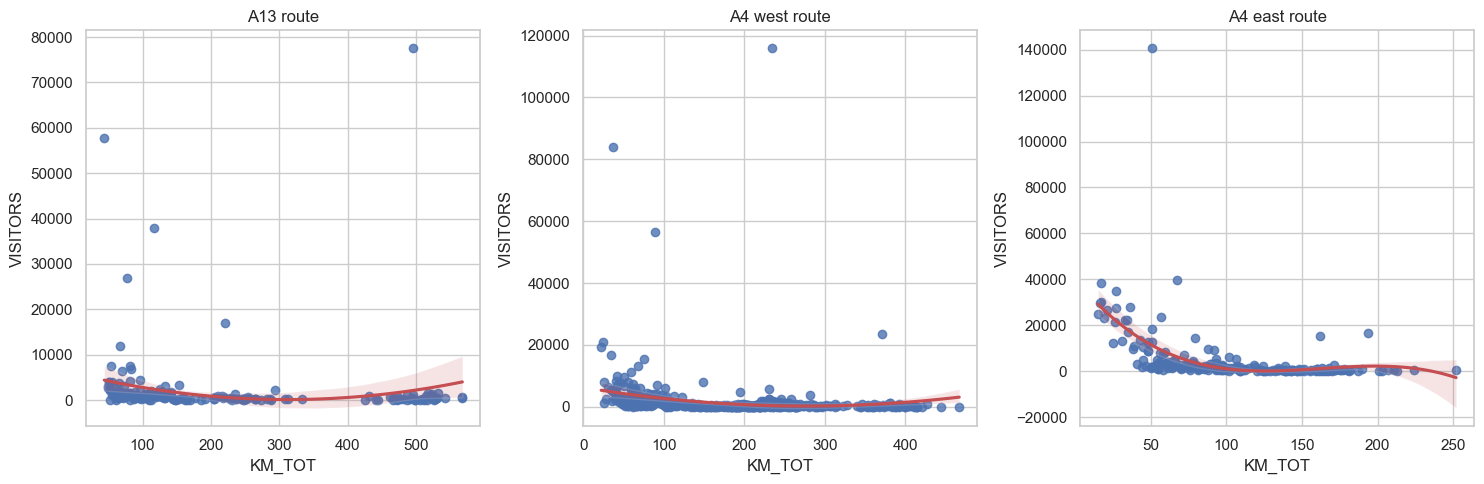

In [7]:
merged_A13_sorted_km = route_A13_merged.sort_values(by='VISITORS')
merged_A4w_sorted_km = route_A4w_merged.sort_values(by='VISITORS')
merged_A4e_sorted_km = route_A4e_merged.sort_values(by='VISITORS')

print("Top discrepancies from each route")
print( pd.concat([merged_A13_sorted_km.nlargest(1, 'VISITORS')[['COMUNE','KM_TOT', 'VISITORS']], 
                  merged_A4e_sorted_km.nlargest(1, 'VISITORS')[['COMUNE','KM_TOT', 'VISITORS']],
                  merged_A4w_sorted_km.nlargest(1, 'VISITORS')[['COMUNE','KM_TOT', 'VISITORS']]],
                 ignore_index=True))

sns.set(style="whitegrid")

# Create scatterplot with regression line
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
  
# Subplot 1
sns.regplot(x='KM_TOT', y='VISITORS', data=merged_A13_sorted_km, line_kws=dict(color="r"), order=2, ax=axes[0])
axes[0].set_title('A13 route')

# Subplot 2
sns.regplot(x=merged_A4w_sorted_km['KM_TOT'], y=merged_A4w_sorted_km['VISITORS'], line_kws=dict(color="r"), order=2, ax=axes[1])
axes[1].set_title('A4 west route')

# Subplot 3
sns.regplot(x='KM_TOT', y='VISITORS', data=merged_A4e_sorted_km, line_kws=dict(color="r"), order=3, ax=axes[2])
axes[2].set_title('A4 east route')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

__In conclusion__:

There are three routes A13, A4 west and A4 east, such that visitors coming from the provinces through these routes estimated with polynomial regression.

Top 5 discrepancies in A13 route are the number of visitors coming from Roma, Rovigo, Bologna, Ferrara, Firenze, respectively.

Top 4 discrepancies in A4 west route are the number of visitors coming from Milano, Vicenza, Verona, Torino.

Top one discrepancy in A4 east route are the number of visitoes coming from Venezia